In [1]:
# This Python 3 environment comes with many helpful analytics librariesacorr installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import pydicom
import os
import glob
import warnings
import seaborn as sns
import re
from pathlib import Path
import torch
from sklearn.model_selection import train_test_split

# Dataset

In [2]:
train = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
print("Total Cases: ", len(train))

Total Cases:  1975


In [3]:
len(train.study_id.unique())

1975

In [4]:
train_series_path= "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv"
train_series = pd.read_csv( train_series_path)
train_series.head(5)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [5]:
train_series.isnull().sum()

study_id              0
series_id             0
series_description    0
dtype: int64

In [6]:
len(train_series.study_id.unique())

1975

In [7]:
train_label_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv'
train_label = pd.read_csv(train_label_path)
train_label.head(5)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [8]:
len(train_label.study_id.unique())

1974

In [9]:
train_label.isnull().sum()

study_id           0
series_id          0
instance_number    0
condition          0
level              0
x                  0
y                  0
dtype: int64

# Distributions Plot 

In [10]:
# find new table for different conditions of spine
data = {}
l = ['foraminal', 'canal', 'subarticular']
for i, name in enumerate(l):
    data[i] = pd.DataFrame()
    for column in list(filter(lambda x: x.find(name) > -1, train.columns)):
        data[i] = pd.concat((data[i], train[column].value_counts()), axis = 1)
    data[i].columns = list(filter(lambda x: x.find(name)>-1, train.columns))

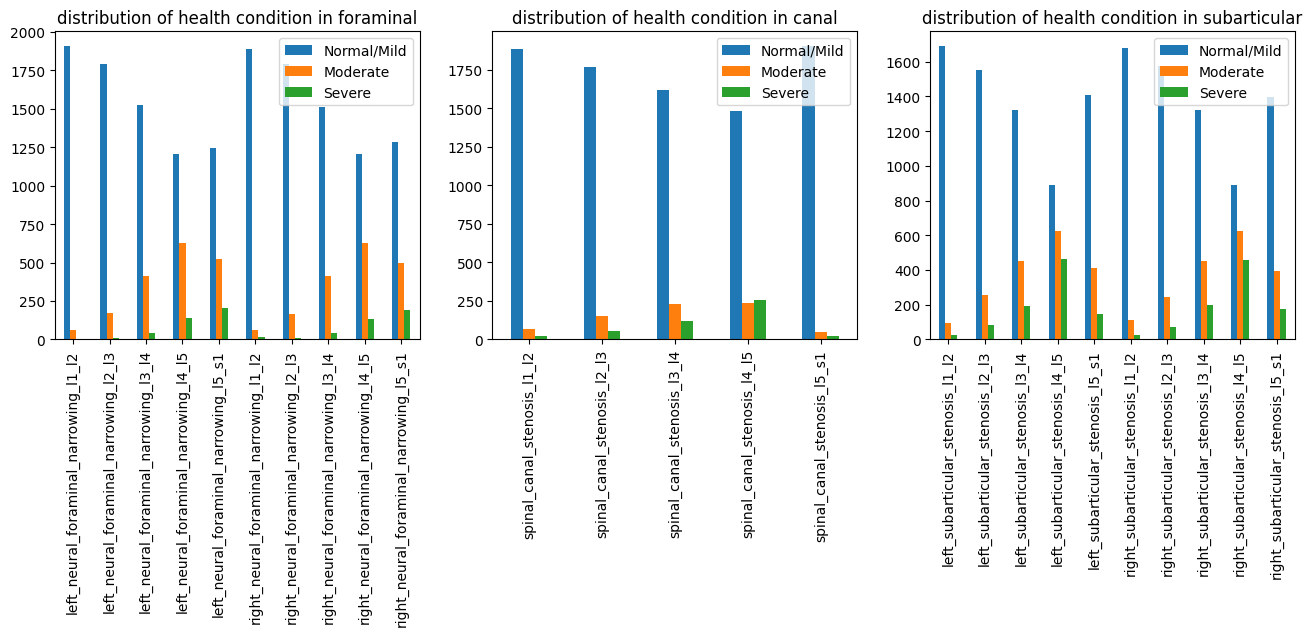

In [11]:
#plot the distribution of health condition
fig, axes = plt.subplots(1, 3, figsize = (16, 4))
for i in range(3):
    data[i].T.plot(kind = 'bar', ax= axes[i])
    axes[i].set_title(f'distribution of health condition in {l[i]}')
plt.show()

# Engineering features in trian_label_coordinate

**Add another health condition in each part of spine and series_description in train_label_coordinate**

In [12]:
train_label1 = train_label.copy()
condition = train_label1["condition"].str.lower() + '_' + train_label1['level'].str.lower()
condlevel = [re.sub(' ', '_', i) for i in condition]
train_label1 = train_label1.assign(condlevel = condlevel).drop(columns = ['condition', 'level'])
train_label1['condlevel'] = train_label1['condlevel'].str.replace('/', '_')
train_label1.head()
# add conditionlevel 

,study_id,series_id,instance_number,x,y,condlevel
0,4003253,702807833,8,322.831858,227.964602,spinal_canal_stenosis_l1_l2
1,4003253,702807833,8,320.571429,295.714286,spinal_canal_stenosis_l2_l3
2,4003253,702807833,8,323.030303,371.818182,spinal_canal_stenosis_l3_l4
3,4003253,702807833,8,335.292035,427.327434,spinal_canal_stenosis_l4_l5
4,4003253,702807833,8,353.415929,483.964602,spinal_canal_stenosis_l5_s1


In [13]:
train_label.isnull().sum()

study_id           0
series_id          0
instance_number    0
condition          0
level              0
x                  0
y                  0
dtype: int64

In [14]:
# Melt dataframe to get column in format for joining training datasets
temp = train
train_label2 = temp.melt(
    id_vars = 'study_id',
    var_name = 'condlevel',
    value_name = 'health',
    ignore_index = True
)
train_label2.isnull().sum()

study_id       0
condlevel      0
health       572
dtype: int64

In [15]:
# train_label2 has some missing values in health, so drop these health which has no values
train_label3 = train_label2.copy()
train_label3 = train_label2.dropna()
# Join train dataframes on study_id and cond_level
train2 = pd.merge(train_label1, train_label3, on = ['study_id', 'condlevel'], how = 'inner')
# Join train2 and train series on study_id and series_id
train2 = pd.merge(train2, train_series, on = ['study_id', 'series_id'], how = 'inner')

# join the condlevel and health for each row in train 2
train2['condlevelhealth'] = train2['condlevel'] + ': '+ train2['health']
train2['series_id'] = train2['series_id'].astype(pd.Int64Dtype())
train2['instance_number'] = train2['instance_number'].astype(pd.Int64Dtype())
train2.isnull().sum()

study_id              0
series_id             0
instance_number       0
x                     0
y                     0
condlevel             0
health                0
series_description    0
condlevelhealth       0
dtype: int64

In [16]:
len(train2.study_id.unique())

1974

In [17]:
# check the value_counts of series_description
train2.series_description.value_counts()

series_description
Sagittal T1         19694
Axial T2            19215
Sagittal T2/STIR     9748
Name: count, dtype: int64

**Explianation:**
* Sagittal T1: left_neural_foraminal_narrowing, right_neural_foraminal_narrowing
* Axial T2: left_subarticular_stenosis, right_subarticular_stenosis
* Sagittal T2/STIR: spinal_canal_stenosis

In [18]:
# Read all images of patient: study_id = 4003253
#imagepath = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253'
#os.listdir(imagepath)


In [19]:
#this is a generator 
#d = os.walk('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253')
#[x[0] for x in d]

In [20]:
#next(os.walk('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253'))[0]

In [21]:
#imagepath = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253'
#get all subdirectory of 4003253
#imagepath = Path(imagepath)
#[x for x in imagepath.iterdir() if x.is_dir()]

In [22]:
#find all PosixPoth subdirectory under the path odf imagepath 
#j = list(imagepath.glob('**/*.dcm'))

# Self definition of function

**print_image_keywords(study_id, keywords) :print image of keywords(keywords are limited to : spinal_canal, left_neural_foraminal, right_neural_foraminal, left_subarticular, and right_subarticular)**

In [23]:
def print_image_keywords(study_id, keywords = 'spinal_canal'):
    cor_dictionary = {
        'Normal/Mild' : 'Green',
        'Moderate': 'Blue',
        'Severe': 'Red'
    }
    if keywords not in ['spinal_canal', 'left_neural_foraminal', 'right_neural_foraminal', 'left_subarticular', 'right_subarticular']:
        print('keywords has some mistakes, import correct keywords again, keyword are limited to : spinal_canal, left_neural_foraminal, right_neural_foraminal, left_subarticular, and right_subarticular')
    else:
        
        condition1 = train2['study_id'] == study_id
        patient_table = train2[condition1]
        condlevel_patient = patient_table.set_index('condlevel').filter(like = keywords, axis = 0 )
        #remove data has missing values
        condlevel_patient = condlevel_patient.dropna()
        #find the health of these condlevel and series_description
        health = condlevel_patient['condlevelhealth']
        health1 = condlevel_patient['health']
        description = condlevel_patient['series_description']
        # find the corresponding image of this patient
        condlevel_patient = condlevel_patient.reset_index()
        # add position of the patient in this image 
        x = condlevel_patient['x']
        y = condlevel_patient['y']
        image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'+ '/'+ condlevel_patient['study_id'].astype(str) + '/'+ condlevel_patient['series_id'].astype(str) +'/' +condlevel_patient['instance_number'].astype(str) + '.dcm'
        image_path = [Path(i) for i in image_path]
        fig, ax = plt.subplots(1,len(image_path), figsize = (18,6))
        ax = ax.flatten()
    for i in range(len(image_path)):
        # read the images into pixel_array
        image = pydicom.dcmread(image_path[i]).pixel_array
        ax[i].imshow(image, cmap = 'gray')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        # get the postion of the patient
        ax[i].scatter(x[i], y[i], color = cor_dictionary.get(health1.iloc[i]))
        # get the title for each image
        ax[i].set_title(f'health condition:\n {health.iloc[i]}, \n description: \n {description.iloc[i]}',  fontsize = 7)
    plt.show()

    #for i in range(len(image_path), len(ax)):
       # ax[i].axis('off')
    #plt.show()

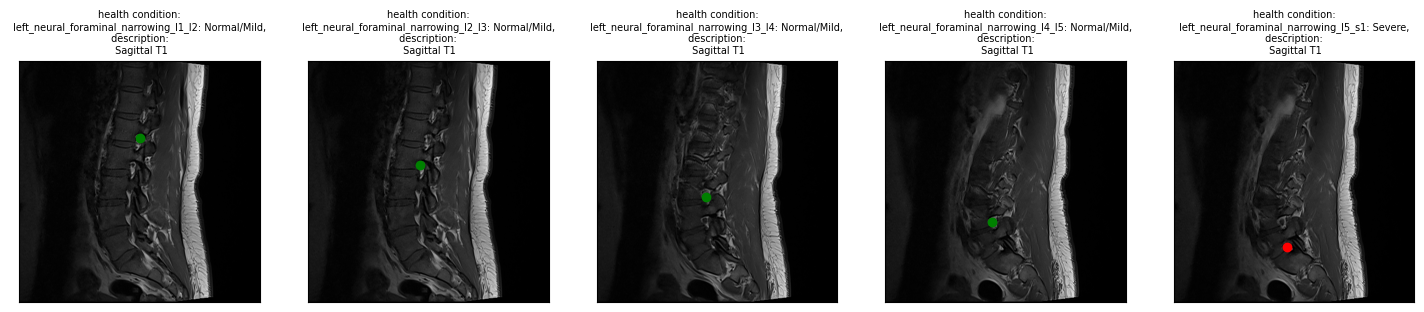

In [24]:
print_image_keywords(4284048608, 'left_neural_foraminal' )

print_all_image: function which print patient image: the first row is about the iamge of spinal_canal_stenosis, the second row is about left_neural_foraminal_narrowing, the third is about right_neural_foraminal_narrowing, the fourth is about left_subarticular_stenosis, the fifth row is about right_subarticular_stenosis, and also return the patient health condition

In [25]:
def print_all_image(study_id):
    condition1 = train2['study_id']==study_id
    patient = train2[condition1]
    key_list = ['spinal_canal', 'right_neural_foraminal', 'left_neural_foraminal', 'left_subarticular', 'right_subarticular']
    for i, key in enumerate(key_list):
        print_image_keywords(study_id, keywords = key)
        
    # explianation of the patient
    
    # all condition in train2
    y_list = train2['condlevel'].unique()
    print(f'Patient : {study_id}')
    for i, key in enumerate(y_list):
        condlevel_patient = patient.set_index('condlevel').filter(like = key, axis = 0 )
        #remove data has missing values
        condlevel_patient = condlevel_patient.dropna()   
        #find the health of these condlevel and series_description
        health = condlevel_patient['condlevelhealth']
        try:
            print(f'condition: {health.iloc[0]} ')
        except: 
            print(f'{key} :Unkown')

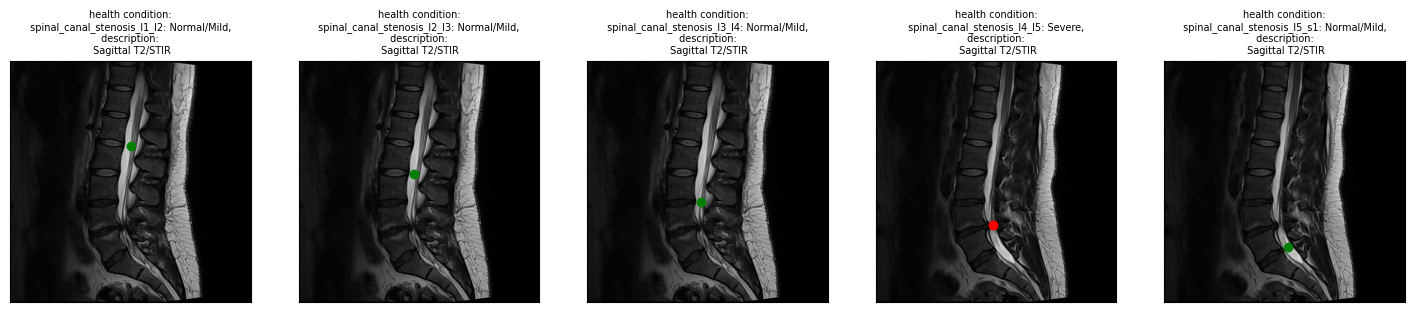

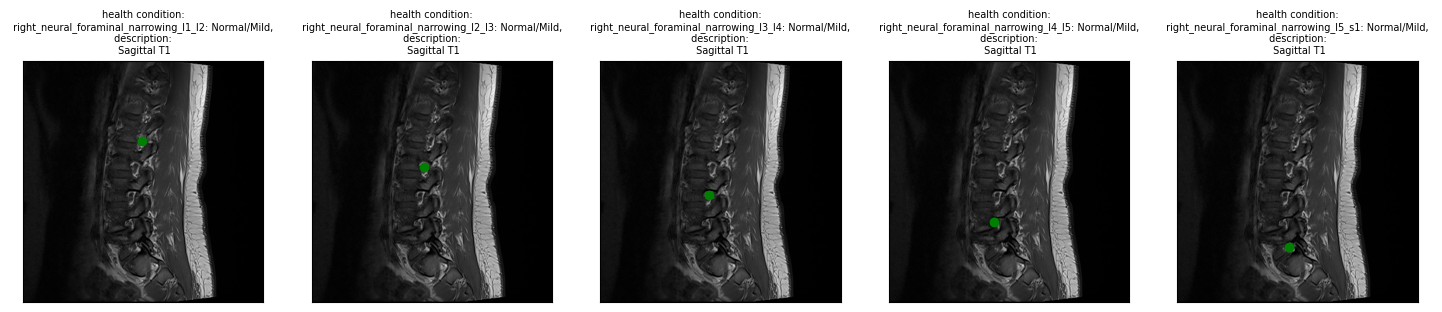

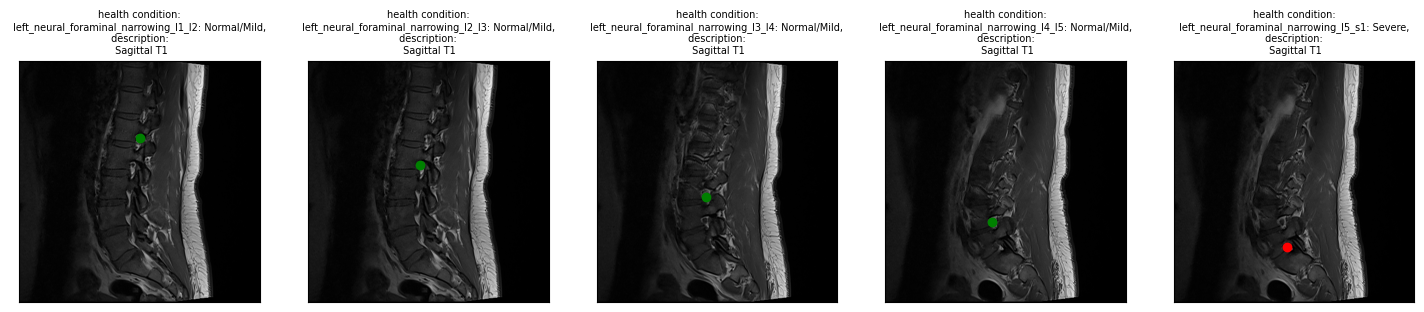

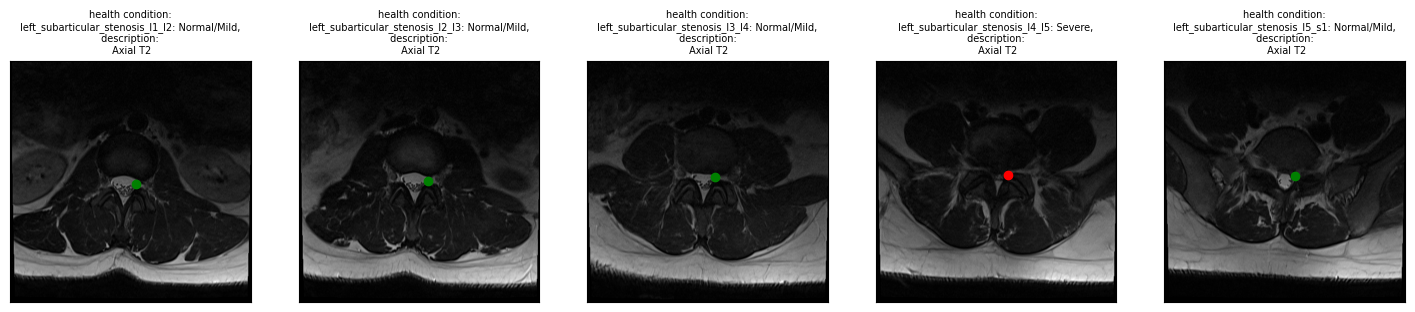

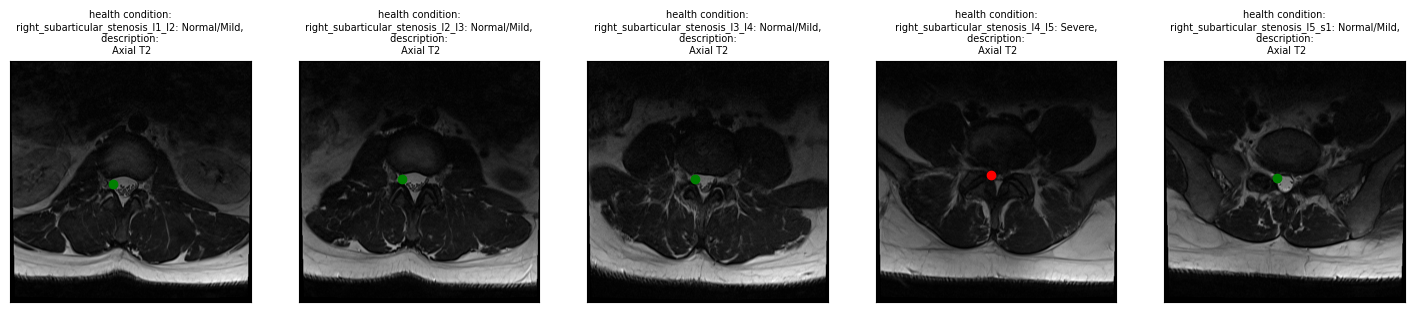

Patient : 4284048608
condition: spinal_canal_stenosis_l1_l2: Normal/Mild 
condition: spinal_canal_stenosis_l2_l3: Normal/Mild 
condition: spinal_canal_stenosis_l3_l4: Normal/Mild 
condition: spinal_canal_stenosis_l4_l5: Severe 
condition: spinal_canal_stenosis_l5_s1: Normal/Mild 
condition: right_neural_foraminal_narrowing_l4_l5: Normal/Mild 
condition: right_neural_foraminal_narrowing_l5_s1: Normal/Mild 
condition: right_neural_foraminal_narrowing_l3_l4: Normal/Mild 
condition: right_neural_foraminal_narrowing_l1_l2: Normal/Mild 
condition: right_neural_foraminal_narrowing_l2_l3: Normal/Mild 
condition: left_neural_foraminal_narrowing_l1_l2: Normal/Mild 
condition: left_neural_foraminal_narrowing_l4_l5: Normal/Mild 
condition: left_neural_foraminal_narrowing_l5_s1: Severe 
condition: left_neural_foraminal_narrowing_l2_l3: Normal/Mild 
condition: left_neural_foraminal_narrowing_l3_l4: Normal/Mild 
condition: left_subarticular_stenosis_l1_l2: Normal/Mild 
condition: right_subarticular_s

In [26]:
print_all_image(4284048608)

# Image Engineering 

In [27]:
#put each path for every data row 
rootpath = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
allpath = rootpath +'/' +  train2['study_id'].astype(str)+ '/' +train2['series_id'].astype(str) + '/' + train2['instance_number'].astype(str) + '.dcm'
train2['allpath'] = allpath
train2.series_description.value_counts()

series_description
Sagittal T1         19694
Axial T2            19215
Sagittal T2/STIR     9748
Name: count, dtype: int64

In [28]:
# group train2 according to series_description 
train_data1 = train2[train2.series_description == 'Sagittal T1']
train_data1.condlevelhealth.value_counts()

condlevelhealth
left_neural_foraminal_narrowing_l1_l2: Normal/Mild     1907
right_neural_foraminal_narrowing_l1_l2: Normal/Mild    1890
right_neural_foraminal_narrowing_l2_l3: Normal/Mild    1793
left_neural_foraminal_narrowing_l2_l3: Normal/Mild     1791
left_neural_foraminal_narrowing_l3_l4: Normal/Mild     1522
right_neural_foraminal_narrowing_l3_l4: Normal/Mild    1512
right_neural_foraminal_narrowing_l5_s1: Normal/Mild    1281
left_neural_foraminal_narrowing_l5_s1: Normal/Mild     1247
right_neural_foraminal_narrowing_l4_l5: Normal/Mild    1208
left_neural_foraminal_narrowing_l4_l5: Normal/Mild     1204
right_neural_foraminal_narrowing_l4_l5: Moderate        628
left_neural_foraminal_narrowing_l4_l5: Moderate         628
left_neural_foraminal_narrowing_l5_s1: Moderate         520
right_neural_foraminal_narrowing_l5_s1: Moderate        495
right_neural_foraminal_narrowing_l3_l4: Moderate        414
left_neural_foraminal_narrowing_l3_l4: Moderate         410
left_neural_foraminal_na

In [29]:
#remove the spine_canal_stenosis conditoion in train_data1 so that sagittal T1 only can
#detect right neural foraminal or left neural foraminal 

condition1 = train_data1.condlevelhealth == "spinal_canal_stenosis_l1_l2: Normal/Mild"
condition2 = train_data1.condlevelhealth == "spinal_canal_stenosis_l2_l3: Normal/Mild"
condition3 = train_data1.condlevelhealth == "spinal_canal_stenosis_l3_l4: Moderate"
condition4 = train_data1.condlevelhealth == "spinal_canal_stenosis_l4_l5: Severe"
condition5 = train_data1.condlevelhealth == "spinal_canal_stenosis_l5_s1: Normal/Mild"
train_data1_1 = train_data1[~(condition1|condition2|condition3|condition4|condition5)]
train_data2 = train2[train2.series_description == 'Axial T2']
train_data3 = train2[train2.series_description == 'Sagittal T2/STIR']

In [30]:
# change condlevelhealth to numerical in train_data1_1, trian_data2, and train_data3
target1 = pd.get_dummies(train_data1_1['condlevelhealth'],dtype = float)
target2 = pd.get_dummies(train_data2['condlevelhealth'], dtype = float)
target3 = pd.get_dummies(train_data3['condlevelhealth'], dtype = float)

imapath1 = train_data1_1['allpath']
imapath2 = train_data2['allpath']
imapath3 = train_data3['allpath']

In [31]:
# split imapath1 and target1
train_imapath1, test_imapath1, train_target1, test_target1 = train_test_split(imapath1, target1, train_size = 0.6,\
                                                                              random_state= 123, shuffle = True, stratify = target1)

# split imapath2 and target2
train_imapath2, test_imapath2, train_target2, test_target2 = train_test_split(imapath2, target2, train_size = 0.6,\
                                                                              random_state= 123, shuffle = True, stratify = target2)

# split imapath3 and target3
train_imapath3, test_imapath3, train_target3, test_target3 = train_test_split(imapath3, target3, train_size = 0.6,\
                                                                              random_state= 123, shuffle = True, stratify = target3)


In [32]:
# use transform in torchvision to change all image in the same size
import torchvision.transforms as transforms
height = 96
width = 96
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((height, width))])

In [33]:
# Bulid a joint tensor dataset imapath with target
from torch.utils.data import Dataset, DataLoader
class ImaTarget(Dataset):
    def __init__(self, imapath, target, transform):
        self.imapath = imapath.to_numpy()
        self.target = torch.tensor(target.to_numpy().astype(float))
        self.transform = transform
    
    def __getitem__(self, index):
        pixel_array = pydicom.dcmread(self.imapath[index]).pixel_array.astype(float)
        pixel_array = self.transform(pixel_array)
        label = self.target[index]
        return pixel_array, label
    
    def __len__(self):
        return len(self.imapath)

In [34]:
# change all train or test imapath or target to all tensor 
train_joint1 = ImaTarget(train_imapath1, train_target1, transform)
test_joint1 = ImaTarget(test_imapath1, test_target1, transform)
train_joint2 = ImaTarget(train_imapath2, train_target2, transform)
test_joint2 = ImaTarget(test_imapath2, test_target2, transform)
train_joint3 = ImaTarget(train_imapath3, train_target3, transform)
test_joint3 = ImaTarget(test_imapath3, test_target3, transform)

In [35]:
# Use DataLoader to iter batch 
batch_size = 64
#get picel_array, description, and target
train_dl1 = DataLoader(train_joint1, batch_size = batch_size, shuffle = True, drop_last = True)
test_dl1 = DataLoader(test_joint1, batch_size = batch_size, shuffle = False, drop_last = True)
train_dl2 = DataLoader(train_joint2, batch_size = batch_size, shuffle = True, drop_last = True)
test_dl2 = DataLoader(test_joint2, batch_size = batch_size, shuffle = False, drop_last = True)
train_dl3 = DataLoader(train_joint3, batch_size = batch_size, shuffle = True, drop_last = True)
test_dl3 = DataLoader(test_joint3, batch_size = batch_size, shuffle = False, drop_last = True)

In [36]:
# bulid cnn1 for train_dl1
import torch.nn as nn
cnn1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64  , kernel_size = 5 , stride = 2 ,padding = 2, dtype = float),
                                 nn.ReLU(), nn.MaxPool2d(kernel_size = 2), nn.Dropout(),
                                nn.Conv2d(in_channels = 64, out_channels = 128 , kernel_size = 5 , stride = 4 ,padding = 2, dtype = float),
                                nn.ReLU(), nn.MaxPool2d(kernel_size = 2), nn.Dropout(), 
                                 nn.Conv2d(in_channels = 128, out_channels = 256  , kernel_size = 5 , stride = 2 ,padding = 2, dtype = float),
                                 nn.ReLU(), nn.MaxPool2d(kernel_size = 2), nn.Dropout(),
                                 nn.Flatten(), nn.Linear(256, 50, dtype = float),
                                nn.ReLU(), nn.Dropout(), nn.Linear(50, 30, dtype = float))
#bulid cnn2 for train_dl2
cnn2 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64  , kernel_size = 5 , stride = 2 ,padding = 2, dtype = float),
                                 nn.ReLU(), nn.MaxPool2d(kernel_size = 2), nn.Dropout(),
                                nn.Conv2d(in_channels = 64, out_channels = 128 , kernel_size = 5 , stride = 4 ,padding = 2, dtype = float),
                                nn.ReLU(), nn.MaxPool2d(kernel_size = 2), nn.Dropout(),
                                nn.Conv2d(in_channels = 128, out_channels = 256 , kernel_size = 5 , stride = 2 ,padding = 2, dtype = float),
                                 nn.ReLU(), nn.MaxPool2d(kernel_size = 2), nn.Dropout(), 
                                 nn.Flatten(), nn.Linear(256, 50, dtype = float),
                                nn.ReLU(), nn.Dropout(), nn.Linear(50, 30, dtype = float))
#bulid cnn3 for train_dl3
cnn3 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64  , kernel_size = 5 , stride = 2 ,padding = 2, dtype = float),
                                 nn.ReLU(), nn.MaxPool2d(kernel_size = 2), nn.Dropout(),
                                nn.Conv2d(in_channels = 64, out_channels = 128 , kernel_size = 5 , stride = 4 ,padding = 2, dtype = float),
                                nn.ReLU(), nn.MaxPool2d(kernel_size = 2), nn.Dropout(),
                                 nn.Conv2d(in_channels = 128, out_channels = 256  , kernel_size = 5 , stride = 2 ,padding = 2, dtype = float),
                                 nn.ReLU(), nn.MaxPool2d(kernel_size = 2), nn.Dropout(),
                                 nn.Flatten(), nn.Linear(256, 50, dtype = float),
                                nn.ReLU(), nn.Dropout(), nn.Linear(100, 15, dtype = float))

In [37]:
#self definition function to train and test train_dl and test_dl, 
def train_model(model, train_dl, test_dl, num_epoch = 30):
    # Create loss function 
    #loss_fn = nn.NLLLoss()
    loss_fn = nn.CrossEntropyLoss(reduction = 'sum')
    #create optimizer to update weight and bias 
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    loss_hist_train = [0.0]* num_epoch
    accuracy_hist_train = [0.0] * num_epoch
    loss_hist_test = [0.0]* num_epoch
    accuracy_test = [0.0]* num_epoch
    for epoch in range(num_epoch):
        model.train()
        for pixel_array,target in train_dl:
            predpossiblity = model(pixel_array)
            loss = loss_fn(predpossiblity, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = (torch.argmax(predpossiblity, dim = 1) == torch.argmax(target, dim = 1)).float().sum()
            accuracy_hist_train[epoch] += is_correct
        loss_hist_train[epoch]/= len(train_dl)
        accuracy_hist_train[epoch]/= len(train_dl.dataset)
    # test the model on test dataloader
        model.eval()
        with torch.no_grad():
            for pixel_array_test, target_test in test_dl:
                pred_test = model(pixel_array_test)
                is_correct_test = (torch.argmax(pred_test, dim = 1) == torch.argmax(target_test, dim = 1)).float().sum()
                accuracy_test[epoch] += is_correct_test
        accuracy_test[epoch] /= len(test_dl.dataset)
        
       
        print(f'the loss of the train_dl is : {loss_hist_train[epoch]}')
        print(f'accuracy of the train_dl is : {accuracy_hist_train[epoch]}')
        print(f'accuracy of the test_dl is : {accuracy_test[epoch]}')

In [38]:
train_model(cnn1, train_dl1, test_dl1, 30)

KeyboardInterrupt: 

In [ ]:
train_model(cnn2, train_dl2, test_dl2, 30)

In [ ]:
train_model(cnn3, train_dl3, test_dl3, 30)

In [ ]:
# 

For each study_id, each seres_id has one series_description

In [ ]:
# different Axial T2 picture contain differernt conjection level, not contain all conjection level.
#this also apply to Sagittal T1 and Sagittal T2/STIR


# extract pixedl_array from train2 allpath
#for i in range(0, len(train2)):
    
